In [2]:
%matplotlib inline

# Linear Models and PyMC3

So far we have covered the tools we need for basic parameter estimation when we have a single unknown parameter. There is a lot you can do with just this information, but the real work horse of statistical modeling is linear models.

In [3]:
from context import src
from src import customer as cust
from src import product as prod
from src import experiment as exp

import pymc3 as pm
import arviz as az

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import expit as logistic

## Revisiting the Toothbrushes as a linear model

In [4]:
toothbrush = prod.Product(name="alright brush",
                          price=4.99,
                          quality=3.9)

luxury_toothbrush = prod.Product(name="luxury toothbrush",
                                 price=7.99,
                                 quality=4.8)

toothbrush_ab_test = exp.Experiment(toothbrush,luxury_toothbrush)
n_samples = 100
experiment_results = toothbrush_ab_test.show_to_customers(n_samples)

In [5]:
purchased = np.concatenate((experiment_results.a_purchased.astype(int),
                            experiment_results.b_purchased.astype(int)))
is_luxury = np.concatenate((np.zeros(n_samples),
                            np.ones(n_samples)))
ab_test_data = pd.DataFrame({
    'purchased' : purchased,
    'is_luxury' : is_luxury
})

In [6]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('purchased ~ 1 + is_luxury',
                            ab_test_data,
                            family=pm.glm.families.Binomial())
    ab_trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [is_luxury, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1455.77draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109966d30>,
      dtype=object)

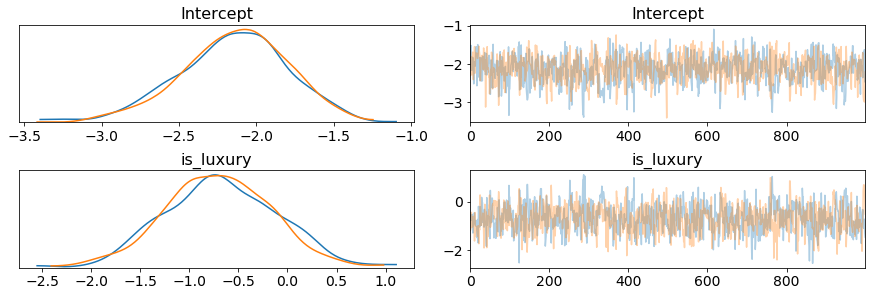

In [7]:
pm.traceplot(ab_trace)

Discuss what this mean in the model...

In [8]:
lo_is_luxury = ab_trace.get_values('is_luxury')

print(sum(lo_is_luxury > 0)/len(lo_is_luxury))

0.1095


In [9]:
lo_regular = ab_trace.get_values('Intercept')

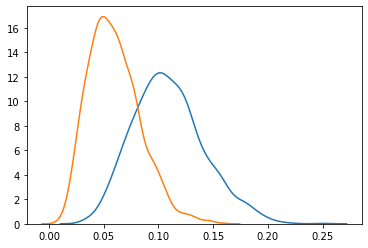

In [11]:
sns.distplot(logistic(lo_regular),hist=False)
sns.distplot(logistic(lo_is_luxury + lo_regular),hist=False)

Compare this with just using our Beta distribution estimates...

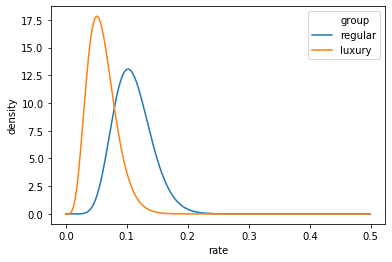

In [13]:
alpha_a = sum(experiment_results.a_purchased)
beta_a = n_samples - alpha_a 
a_beta_dist = stats.beta(alpha_a,beta_a)

alpha_b = sum(experiment_results.b_purchased)
beta_b = n_samples - alpha_b 
b_beta_dist = stats.beta(alpha_b,beta_b)
rates = np.arange(0,0.5,0.001)
plot_df = pd.DataFrame({
    'density':np.concatenate((a_beta_dist.pdf(rates),
                              b_beta_dist.pdf(rates))),
    'rate': np.concatenate((rates,rates)),
    'group':['regular']*len(rates) + ['luxury']*len(rates)
})
sns.lineplot(x='rate',
             y='density',
             hue='group',
             data=plot_df)

nearly the same result!

but why would we care? 

Using a linear model gives us the same result, but also makes it much easier for us to extend our solution to more complicated issues.